<a href="https://colab.research.google.com/github/tsakailab/prml/blob/master/ChestXray/ChestXray_FCN_TL_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, decode_predictions, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import GlobalAveragePooling2D, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import logging
logging.getLogger('tensorflow').disabled = True

In [2]:
if tf.test.is_gpu_available():
    print("The following GPU devices are available: %s" % tf.test.gpu_device_name())
    !/usr/bin/nvidia-smi -L

The following GPU devices are available: /device:GPU:0
GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-5b638882-47d7-17f6-e82c-68457890f061)


#Part II: Transfer Learning

##Data preparation
###Data download and unzip

In [3]:
!wget --no-check-certificate --show-progress -q\
    "https://github.com/tsakailab/prml/raw/master/ChestXray/chest_xray_150x150.zip" \
    -O "/tmp/chest_xray_150x150.zip"

import zipfile
import os
zip_ref = zipfile.ZipFile("/tmp/chest_xray_150x150.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

root_dir = "/tmp/chest_xray_150x150"

class_names = os.listdir(root_dir + "/train")

train, test, val = {}, {}, {}
train_files, test_files, val_files = {}, {}, {}
for class_name in class_names:
    train_files[class_name] = os.listdir(root_dir + "/train/" + class_name)
    test_files[class_name] = os.listdir(root_dir + "/test/" + class_name)
    val_files[class_name] = os.listdir(root_dir + "/val/" + class_name)
print("#training data: %s" % ([(k,len(v)) for (k,v) in train_files.items()]))
print("#test data: %s" % ([(k,len(v)) for (k,v) in test_files.items()]))
print("#val data: %s" % ([(k,len(v)) for (k,v) in val_files.items()]))

train['files'], test['files'], val['files'] = train_files, test_files, val_files

/tmp/chest_xray_150 100%[===================>]  23.37M   100MB/s    in 0.2s    
#training data: [('PNEUMONIA', 3875), ('NORMAL', 1349)]
#test data: [('PNEUMONIA', 390), ('NORMAL', 234)]
#val data: [('PNEUMONIA', 8), ('NORMAL', 8)]


##Setting image generators for data augmentation

In [0]:
train['gen'] = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=1,
    width_shift_range=0.,
    height_shift_range=0.,
    horizontal_flip=False)

test['gen'] = ImageDataGenerator(preprocessing_function=preprocess_input)
val['gen'] = ImageDataGenerator(preprocessing_function=preprocess_input)

In [5]:
train['dir'] = root_dir + "/train"
test['dir'] = root_dir + "/test"
val['dir'] = root_dir + "/val"

target_size = (160, 160)
batch_size = 64

train['flow'] = train['gen'].flow_from_directory(train['dir'],
                                    class_mode="binary",
                                    target_size=target_size,
                                    batch_size=batch_size)

cid_to_class_name = {train['flow'].class_indices[name]: name for name in class_names}
# compute class_weight for the imbalanced training dataset
num_data = {k: len(v) for (k,v) in train['files'].items()}
max_num_data = max(num_data.values())
class_weight = {train['flow'].class_indices[name]: max_num_data/num_data[name] for name in class_names}

n_train = sum(num_data.values())
n_val = sum({k: len(v) for (k,v) in val['files'].items()}.values())
n_test = sum({k: len(v) for (k,v) in test['files'].items()}.values())

test['flow'] = test['gen'].flow_from_directory(test['dir'],
                                   class_mode="binary",
                                   target_size=target_size)

val['flow'] = val['gen'].flow_from_directory(val['dir'],
                                  class_mode="binary",
                                  target_size=target_size)

Found 5224 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


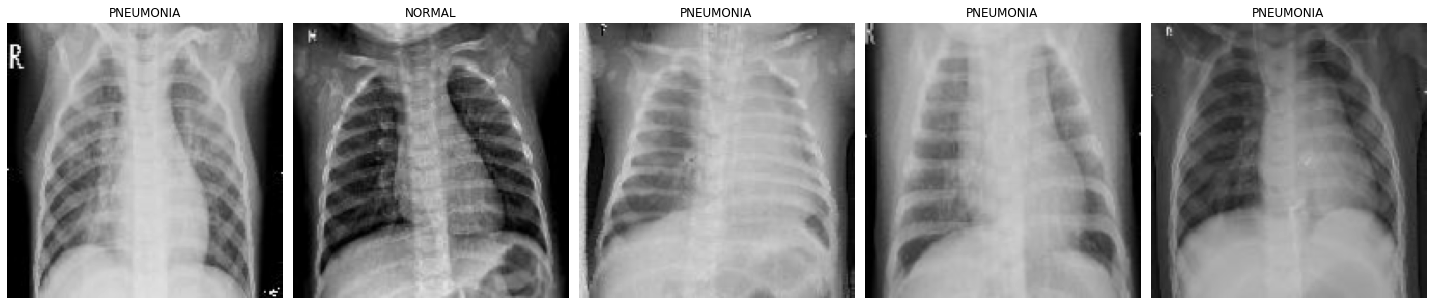

In [6]:
# Show some images from the generator
def plotImages(img_arr, lbl_arr):
    fig, axes = plt.subplots(1, min(len(img_arr), 5), figsize=(20,20))
    axes = axes.flatten()
    for img, lbl, ax in zip( img_arr, lbl_arr, axes):
        ax.imshow(img[:,:,0], cmap='gray', vmin=-1, vmax=1)
        ax.title.set_text(cid_to_class_name[lbl])
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
image_batch, label_batch = next(train['flow'])
plotImages(image_batch, label_batch)

##Transfer learning with MobilenetV2 as a base model

In [0]:
base_model = MobileNetV2(input_shape=(target_size[0], target_size[1], 3),
                         include_top=False,
                         weights='imagenet'
                        )

In [8]:
# If you want to see the layer names,
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_1
1 Conv1_pad
2 Conv1
3 bn_Conv1
4 Conv1_relu
5 expanded_conv_depthwise
6 expanded_conv_depthwise_BN
7 expanded_conv_depthwise_relu
8 expanded_conv_project
9 expanded_conv_project_BN
10 block_1_expand
11 block_1_expand_BN
12 block_1_expand_relu
13 block_1_pad
14 block_1_depthwise
15 block_1_depthwise_BN
16 block_1_depthwise_relu
17 block_1_project
18 block_1_project_BN
19 block_2_expand
20 block_2_expand_BN
21 block_2_expand_relu
22 block_2_depthwise
23 block_2_depthwise_BN
24 block_2_depthwise_relu
25 block_2_project
26 block_2_project_BN
27 block_2_add
28 block_3_expand
29 block_3_expand_BN
30 block_3_expand_relu
31 block_3_pad
32 block_3_depthwise
33 block_3_depthwise_BN
34 block_3_depthwise_relu
35 block_3_project
36 block_3_project_BN
37 block_4_expand
38 block_4_expand_BN
39 block_4_expand_relu
40 block_4_depthwise
41 block_4_depthwise_BN
42 block_4_depthwise_relu
43 block_4_project
44 block_4_project_BN
45 block_4_add
46 block_5_expand
47 block_5_expand_BN
48 block_5_exp

### Model definition: fully convolutional network (FCN) with global average pooling (GAP)

In [9]:
layer_name='block_5_add'
bbone = tf.keras.Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)

def FCNmodel(backbone=bbone, trainable_backbone=True):
    backbone = tf.keras.models.clone_model(bbone)
    backbone.set_weights(bbone.get_weights())
    backbone.trainable = trainable_backbone
    return  tf.keras.Sequential([
        backbone,
        tf.keras.layers.Conv2D(2, (3,3), activation='relu', padding='same'),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ])

model = FCNmodel()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 20, 20, 32)        59008     
_________________________________________________________________
conv2d (Conv2D)              (None, 20, 20, 2)         578       
_________________________________________________________________
global_average_pooling2d (Gl (None, 2)                 0         
_________________________________________________________________
activation (Activation)      (None, 2)                 0         
Total params: 59,586
Trainable params: 56,066
Non-trainable params: 3,520
_________________________________________________________________


### Training (the model is initialized every single epoch if overfits)

In [10]:
model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy', metrics=['accuracy'])


steps = n_train//batch_size
DESIRED_VAL_ACCURACY = 0.80
nretry = 4
for i in range(nretry):
    history = model.fit(train['flow'], initial_epoch=0, epochs=1, class_weight=class_weight, 
                                    steps_per_epoch=steps, validation_steps=steps,
                                    validation_data=val['flow'])
    if history.history['val_accuracy'][-1] > DESIRED_VAL_ACCURACY:
        break
    else:
        if i < nretry - 1:  # initialize and retry
            model = FCNmodel()
            model.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        else:
            print("Cannot get a good model. Execute this cell again.")

81/81 [==============================] - 31s 386ms/step - loss: 0.2728 - accuracy: 0.9186 - val_loss: 0.2951 - val_accuracy: 0.8750


## Evaluation of the prediction performance

In [11]:
#print(model.evaluate_generator(test['flow']))
score = model.evaluate(test['flow'], steps=n_test)
print('Test Loss: {:3f}, Test Accuracy: {:.2f}'.format(score[0], score[1]))
num_test = {k: len(v) for (k,v) in test['files'].items()}
print("Chance rate of PNEUMONIA: %.2f" % (num_test['PNEUMONIA']/sum(num_test.values())))

624/624 [==============================] - 17s 27ms/step - loss: 0.3364 - accuracy: 0.8830
Test Loss: 0.336377, Test Accuracy: 0.88
Chance rate of PNEUMONIA: 0.62


In [12]:
print(num_test)

{'PNEUMONIA': 390, 'NORMAL': 234}


Model predictions (blue: correct, red: incorrect)


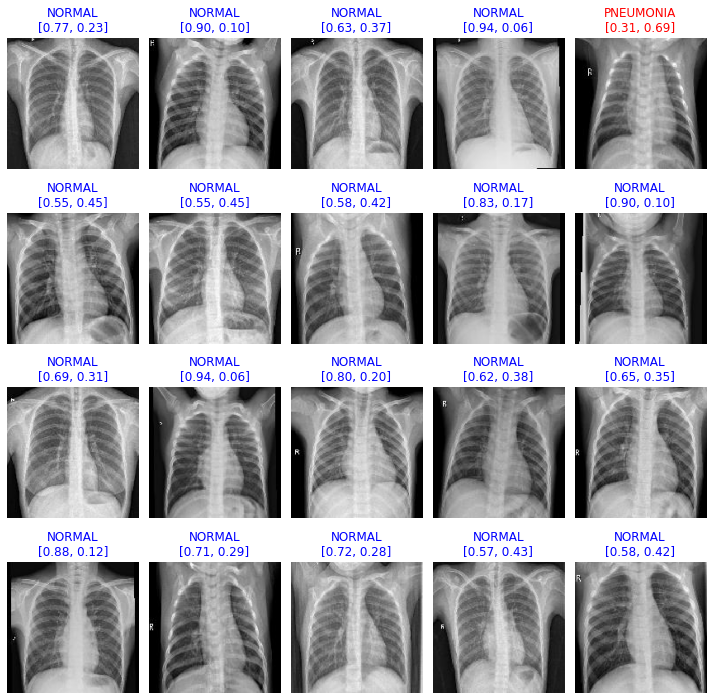

In [13]:
#### Choose the dataset and class_name ####
dataset = test  # train, val, test
class_name = 'NORMAL'
#class_name = 'PNEUMONIA'
##################################

from time import time
rng = np.random.RandomState(int(time()))
ids = rng.choice(len(dataset['files'][class_name]), 20, replace=False)

print("Model predictions (blue: correct, red: incorrect)")
fig, axes = plt.subplots(4,5, figsize=(10,10))
axes = axes.flatten()
for data_id, ax in zip(ids, axes):
    gt_class_name = class_name
    file = dataset['files'][gt_class_name][data_id]
    img_in = load_img(dataset['dir'] + '/' + gt_class_name + '/' + file, target_size=target_size)
    x = preprocess_input(np.expand_dims(img_to_array(img_in), axis=0))
    pred = model.predict(x)
    cid_pred = np.argmax(pred[0])
    pred_class_name = cid_to_class_name[cid_pred]

    ax.imshow(img_in, cmap='gray', vmin=-1, vmax=1)
    ax.axis('off')
    ax.set_title(pred_class_name + '\n[%.2f, %.2f]' % (pred[0][0], pred[0][1]), 
                 color='blue' if pred_class_name == gt_class_name else 'red')

plt.tight_layout()
plt.show()

Visualizing feature maps before GAP for an image of the class PNEUMONIA in training dataset


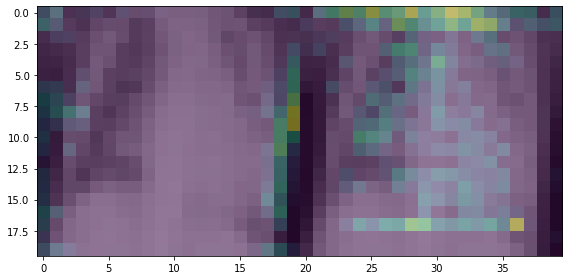

Ground truth: PNEUMONIA [0.09488082 0.9051191 ]  Predicted label: PNEUMONIA


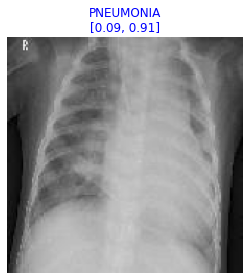

In [18]:
#### Choose the dataset and class_name ####
dataset = test  # train, val, test
#class_name = 'NORMAL'
class_name = 'PNEUMONIA'
##################################

gt_class_name = class_name

import numpy as np
import random
file = random.choice(dataset['files'][class_name])
img_in = load_img(dataset['dir'] + '/' + gt_class_name + '/' + file, target_size=target_size)
x = preprocess_input(np.expand_dims(img_to_array(img_in), axis=0))

print("Visualizing feature maps before GAP for an image of the class %s in training dataset" % (class_name))
visualization_model = tf.keras.models.Model(inputs = model.input, 
                                            outputs=model.layers[-3].output)
feature_maps_before_GAP = visualization_model.predict(x)

n_features = feature_maps_before_GAP.shape[-1]
size = feature_maps_before_GAP.shape[1]
display_grid = np.zeros((size, size * n_features))
maps_min = feature_maps_before_GAP[0,:,:,:].min()
maps_max = feature_maps_before_GAP[0,:,:,:].max()
for i in range(n_features):
    y = feature_maps_before_GAP[0,:, :, i]
    y = (y - maps_min) / (maps_max - maps_min) * 255
    y = np.clip(y, 0, 255)
    display_grid[:, i * size : (i + 1) * size] = y
scale = 4.
plt.figure(figsize=(scale * n_features, scale))
plt.grid(False)

plt.imshow(np.tile(np.array(img_in.resize((size,size))), (1, 2, 1)), aspect='auto', cmap='gray')
plt.gca().imshow(display_grid, aspect='auto', alpha=0.4, cmap='viridis') #cmap='jet')
plt.tight_layout()
plt.show()

pred = model.predict(x)
cid_pred = np.argmax(pred[0])
pred_class_name = cid_to_class_name[cid_pred]
print("Ground truth: " + gt_class_name + " " + str(pred[0]) + "  Predicted label: " + pred_class_name)

plt.figure()
plt.imshow(img_in, cmap='gray', vmin=-1, vmax=1)
plt.axis('off')
plt.title(pred_class_name + '\n[%.2f, %.2f]' % (pred[0][0], pred[0][1]), 
          color='blue' if pred_class_name == gt_class_name else 'red')
plt.tight_layout()
plt.show()